## PART 3: PEAK HOUR ANALYSIS


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns


path = '../data/dataframe.csv'
df = pd.read_csv(path)

# INITIAL DATA MANIPUNATION
df['reference_date'] = pd.to_datetime(df['reference_date'], utc=True).dt.tz_localize(None) 
df = df.sort_values(by='reference_date') 
# Reindex the dataframe to include all timestamps
full_range = pd.date_range(df['reference_date'].min(),
                           df['reference_date'].max(),
                           freq='h')
df = df.set_index('reference_date').reindex(full_range)
# Interpolate missing values (linear ones)
df = df.interpolate(method='linear')
df = df.reset_index().rename(columns={'index': 'reference_date'})
df.set_index('reference_date', inplace=True)
df_filtered = df.loc[:'2025-09-22 23:00:00'] # Filter on last avaiable Price observation

#### 6. Intraday Pattern Analysis
    - Extract hour-of-day information and create hourly price profiles
    - Identify the typical morning and evening peak hours
    - Quantify the magnitude of these price spikes

C:\Users\samue\AppData\Local\Temp\ipykernel_8472\3869404946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'hour'] = df_filtered.index.hour


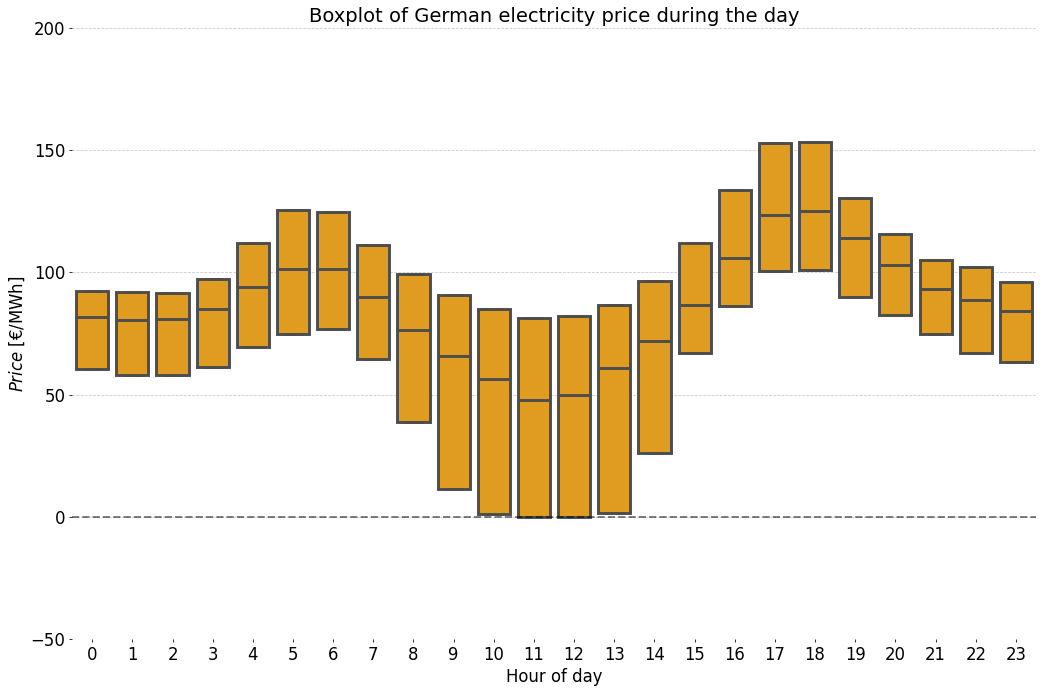

In [2]:
#already done!
DPI = 70

df_filtered.loc[:, 'hour'] = df_filtered.index.hour

# Le specifiche del plot le ho riciclate dalla tesi
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)
sns.boxplot(data=df_filtered, x="hour", y="Price_de", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$Price$ [€/MWh]", fontsize=17)
ax.set_title("Boxplot of German electricity price during the day", fontsize=20)
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim([-50, 200])
plt.tight_layout()
plt.show()

In [22]:
hourly_median = df_filtered.groupby('hour')['Price_de'].median()
morning_peak_hour = hourly_median.loc[4:10].idxmax()#7-10 
evening_peak_hour = hourly_median.loc[17:20].idxmax()#5-8 Pome

morning_peak_hour
evening_peak_hour

np.int32(18)

In [23]:
morning_peak_price = hourly_median[morning_peak_hour]
evening_peak_price = hourly_median[evening_peak_hour]

daily_min_price = hourly_median.min()

# magnitud of those spikes (by difference)
morning_spike = morning_peak_price - daily_min_price
evening_spike = evening_peak_price - daily_min_price

print(f"Morning peak hour: {morning_peak_hour}h, magnitude: {morning_spike:.2f} €/MWh")
print(f"Evening peak hour: {evening_peak_hour}h, magnitude: {evening_spike:.2f} €/MWh")

Morning peak hour: 5h, magnitude: 53.42 €/MWh
Evening peak hour: 18h, magnitude: 77.20 €/MWh


#### 7. Peak Hour Fundamentals
    - What happens to demand during morning and evening peaks?
    - How does renewable generation (particularly solar) vary throughout the day?
    - Analyze the "duck curve" effect - when solar generation is high midday but demand peaks occur when solar output is low/zero

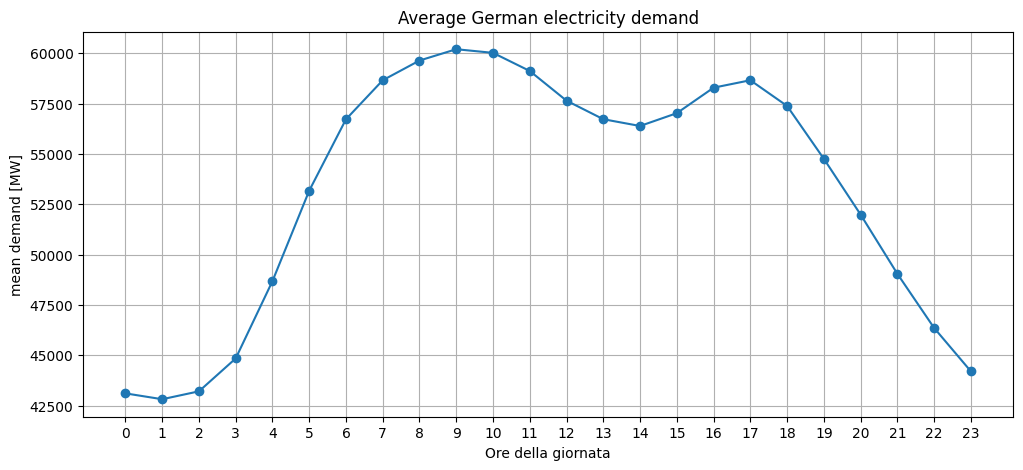

In [5]:
hourly_demand = df_filtered.groupby('hour')['Demand_de'].mean()
hourly_demand

plt.figure(figsize=(12,5))
plt.plot(hourly_demand.index, hourly_demand.values, marker='o')
plt.xlabel("Ore della giornata")
plt.ylabel("mean demand [MW]")
plt.title("Average German electricity demand")
plt.grid(True)
plt.xticks(range(24))
plt.show()

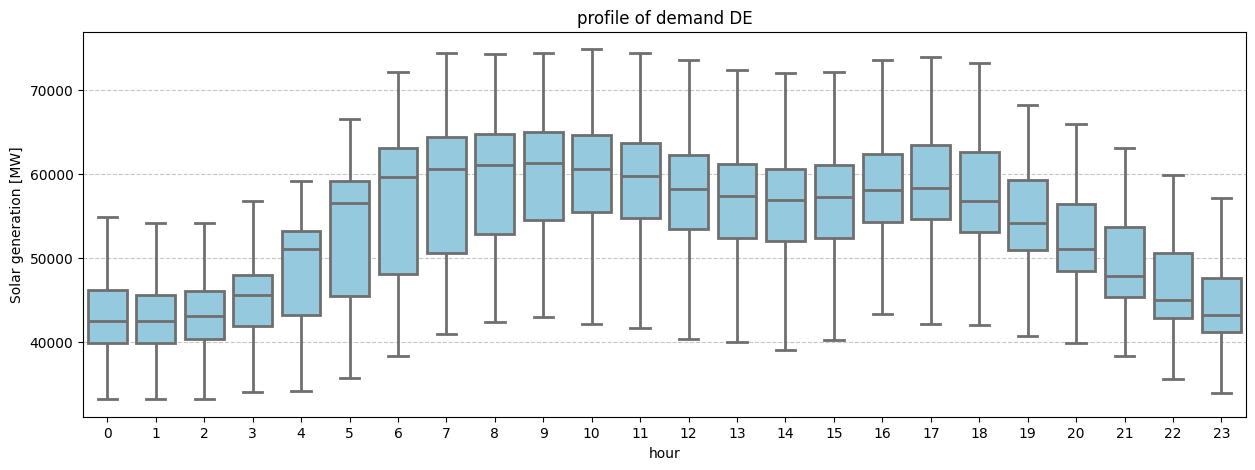

In [6]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_filtered, x="hour", y="Demand_de", color='skyblue', linewidth=2, fliersize=0)
plt.ylabel("Solar generation [MW]")
plt.title("profile of demand DE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

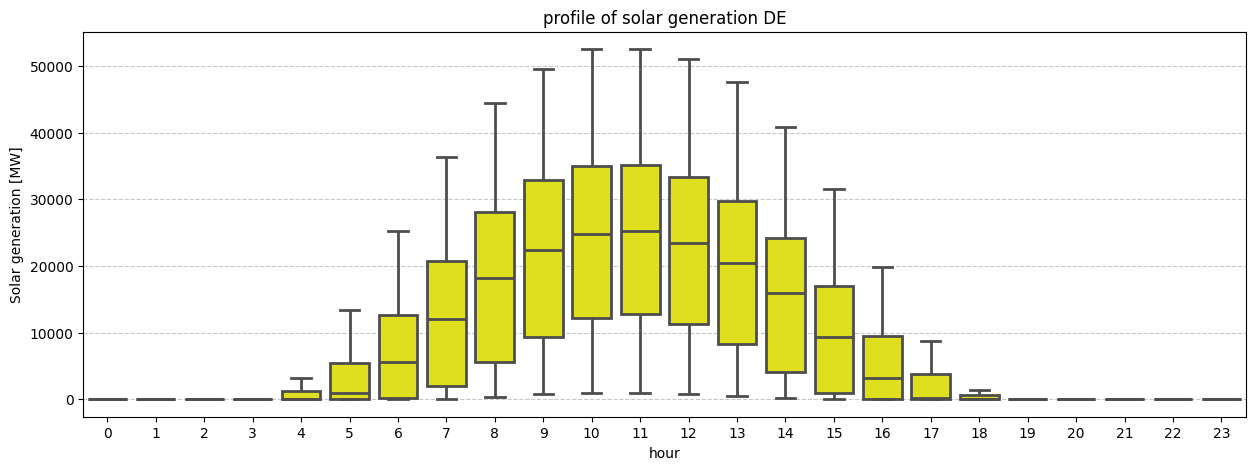

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_filtered, x="hour", y="Solar_de", color='yellow', linewidth=2, fliersize=0)

plt.ylabel("Solar generation [MW]")
plt.title("profile of solar generation DE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_8472\3638762341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_load'] = df_filtered['Demand_de'] - df_filtered['Solar_de'] # mi servirà anche dopo per la parte finale


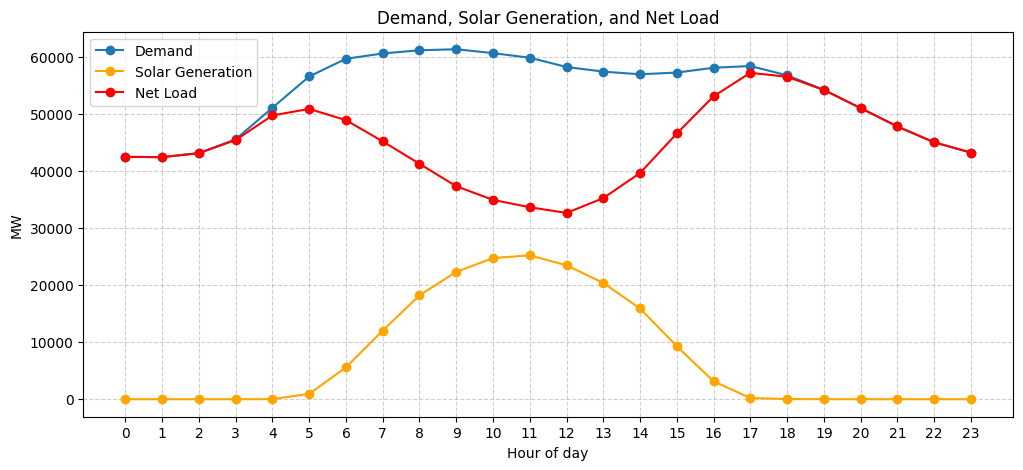

In [8]:
df_filtered['net_load'] = df_filtered['Demand_de'] - df_filtered['Solar_de'] # mi servirà anche dopo per la parte finale
hourly_net_load = df_filtered.groupby('hour')['net_load'].median()
hourly_demand = df_filtered.groupby('hour')['Demand_de'].median()
hourly_solar = df_filtered.groupby('hour')['Solar_de'].median()

plt.figure(figsize=(12,5))
plt.plot(hourly_demand.index, hourly_demand.values, label='Demand', marker='o')
plt.plot(hourly_solar.index, hourly_solar.values, label='Solar Generation', marker='o', color='orange')
plt.plot(hourly_net_load.index, hourly_net_load.values, label='Net Load', marker='o', color='red')

plt.xlabel("Hour of day")
plt.ylabel("MW")
plt.title("Demand, Solar Generation, and Net Load")
plt.legend()
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

solar generation reduces net demand during midday, but the actual demand peaks in the morning and evening when solar is low or zero

#### 8. Merit Order Analysis
    - During peak hours, which generation sources are likely being dispatched?
    - How do marginal generation costs change between peak and off-peak hours?
    - Can you identify the marginal generation technology setting prices during different hours?

In [12]:
peak_hours = df_filtered[df_filtered['hour'].isin([7,18])]  # typical morning/evening peaks

sources = ['Lignite_de', 'Coal_de',  'Gas_de', 'Solar_de', 'Wind_de']
peak_generation = peak_hours[sources].median().sort_values()

print(peak_generation)

Solar_de        979.250
Coal_de        2920.365
Gas_de         4177.790
Lignite_de     8740.955
Wind_de       12213.750
dtype: float64


In [17]:
peak_hours = df_filtered[df_filtered['hour'].isin([7,18])]
offpeak_hours = df_filtered[df_filtered['hour'].isin([1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23])]

median_peak_cost = peak_hours['Cost_de'].median()
median_offpeak_cost = offpeak_hours['Cost_de'].median()

print(f"Median Cost_de during peak hours: {median_peak_cost:.2f} €/MWh")
print(f"Median Cost_de during off-peak hours: {median_offpeak_cost:.2f} €/MWh")

Median Cost_de during peak hours: 98.32 €/MWh
Median Cost_de during off-peak hours: 98.32 €/MWh


In [19]:
df_filtered_1 = df_filtered.copy()

df_filtered_1['hour'] = df_filtered_1.index.hour
sources = [ 'Lignite_de','Coal_de', 'Gas_de', 'Solar_de', 'Wind_de']

hourly_gen = df_filtered_1.groupby('hour')[sources].median()

hourly_gen_sorted = hourly_gen.apply(lambda x: x.sort_values(), axis=1)

hourly_gen_sorted

,Coal_de,Gas_de,Lignite_de,Solar_de,Wind_de
hour,,,,,
0,1979.87000,2634.43000,7877.860,4.75,13984.000
1,1926.18000,2619.96667,7706.810,4.50,13696.250
2,1921.60000,2669.26000,7799.060,5.50,13564.000
3,2105.53333,3016.12334,8166.130,7.25,13589.250
4,2342.47000,3453.22000,8500.710,17.75,13598.750
5,2578.21038,3775.41000,8640.640,947.50,13095.000
6,2696.01000,3736.84000,8556.670,5584.75,12008.250
7,2368.80667,3140.80667,8052.520,12028.75,11480.500
8,2015.29000,2351.32000,7027.730,18198.75,11336.750


In [20]:
# likely marginal technology per hour (highest among fossil fuels)
fossil_sources = ['Lignite_de', 'Coal_de', 'Gas_de']
hourly_marginal = hourly_gen[fossil_sources].idxmax(axis=1)

print("Likely marginal generation technology by hour:")
print(hourly_marginal)



Likely marginal generation technology by hour:
hour
0     Lignite_de
1     Lignite_de
2     Lignite_de
3     Lignite_de
4     Lignite_de
5     Lignite_de
6     Lignite_de
7     Lignite_de
8     Lignite_de
9     Lignite_de
10    Lignite_de
11    Lignite_de
12    Lignite_de
13    Lignite_de
14    Lignite_de
15    Lignite_de
16    Lignite_de
17    Lignite_de
18    Lignite_de
19    Lignite_de
20    Lignite_de
21    Lignite_de
22    Lignite_de
23    Lignite_de
dtype: object
